## Wealth Distributions

### Constant Savings Rate, Impact of Volatility

In [1]:
import numpy as np
from numba import jit, njit, prange
import matplotlib.pyplot as plt
import statsmodels.api as sm
 

/home/john/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### Dynamics

The model is

$$ w_{t+1} = R_{t+1} s_0 w_t + y_{t+1} $$

where

* $w_t$ is wealth at time $t$ for a given household,
* $R_t$ is the gross rate of return of financial assets,
* $y_t$ is current non-financial (e.g., labor) income and
* $s_0$ is a savings rate


Letting $\{z_t\}$ be a correlated state process of the form

$$ z_{t+1} = \rho z_t + (1 - \rho^2)^{1/2} \epsilon_{t+1} $$

we'll assume that

$$ \ln R_t = \mu_r + c_r \exp(z_t) \xi_t $$

and 

$$ y_t = c_y \exp(z_t) + \exp(\mu_y + \sigma_y \zeta_t) $$

Here $\{ (\epsilon_t, \xi_t, \zeta_t) \}$ is IID and standard normal in $\mathbb R^3$.


In [2]:
class WealthDynamics:
    
    def __init__(self,
                 s_0=0.8,    # savings parameter
                 c_y=0.0,     # labor income parameter
                 μ_y=1.5,     # labor income paraemter
                 σ_y=0.2,     # labor income parameter
                 μ_r=0.0,     # rate of return parameter
                 c_r=0.035,     # rate of return parameter
                 ρ=0.1):      # z shock correlation
    
        # Boilerplate
        self.s_0 = s_0
        self.c_y, self.μ_y, self.σ_y = c_y, μ_y, σ_y
        self.c_r, self.μ_r = c_r, μ_r
        self.ρ = ρ
        
        # Compute stationary mean for R and y by MC
        self.R_mean, self.y_mean = self.compute_stationary_means()
        
        # Test stability condition, compute estimate of the stationary
        # mean of w_t
        α = self.R_mean * self.s_0
        if α < 1:
            print(f"Generated instance with stability coefficient α = {α}")
        else:
            raise ValueError(f"Stability condition failed with α = {α}")
         
    def parameters(self):
        """
        Collect and return parameters.
        """
        parameters = (self.s_0, 
                      self.c_y, self.μ_y, self.σ_y,
                      self.c_r, self.μ_r,
                      self.ρ)
        return parameters
                 
    def compute_stationary_means(self):
        # Unpack parameters
        params = self.parameters()
        s_0, c_y, μ_y, σ_y, c_r, μ_r, ρ = params

        @njit
        def csm(mc_size = 10_000):
            np.random.seed(1234)
            z_draws = np.random.randn(mc_size)
            ξ_draws = np.random.randn(mc_size)
            R_mean = 0.0
            Y_mean = 0.0
            for z in z_draws:
                for ξ in ξ_draws:
                    R_mean += np.exp(μ_r + c_r * np.exp(z) * ξ)
                    Y_mean += c_y * np.exp(z) + np.exp(μ_y + σ_y * ξ)
            R_mean = R_mean / (mc_size**2)
            Y_mean = Y_mean / (mc_size**2)
            return R_mean, Y_mean
            
        return csm()

        
    def update_function_builder(self):
        """
        A function factory that returns a function with one task:
        update wealth from w_t to w_{t+1}.
        """
        # Unpack parameters
        params = self.parameters()
        s_0, c_y, μ_y, σ_y, c_r, μ_r, ρ = params
        σ = np.sqrt(1 - ρ**2)
                 
        @njit
        def update_z(z):
            """
            Update exogenous state one period, given current state z.
            """   
            zp = ρ * z + σ * np.random.randn()
            return zp
        
        @njit
        def update_w(w, z):
            """
            Update one period, given current wealth w and next period 
            exogenous state zp.
            """   
            y = c_y * np.exp(z) + np.exp(μ_y + σ_y * np.random.randn())   
            R = np.exp(μ_r + c_r * np.exp(z) * np.random.randn())
            wp = R * s_0 * w + y
            return wp
        
        return update_z, update_w
    

Here's a function to simulate wealth of a single household.

In [3]:
@njit
def wealth_time_series(w_0, z_0, g, h, ts_length=10_000):
    """
    Generate a single time series for wealth.
    """
    z = np.empty(ts_length)
    z[0] = z_0
    w = np.empty(ts_length)
    w[0] = w_0
    for t in range(ts_length-1):
        z[t+1] = g(z[t])
        w[t+1] = h(w[t], z[t+1])
    return w

Here's a function to simulate a cross section.

In [4]:
def cross_section_ideosyncratic_z(wd, w_distribution, z_0, shift_length=500, seed=1234):
    """
    Takes a current distribution of wealth values as w_distribution
    and updates each w_t in w_distribution to w_{t+j}, where 
    j = shift_length.  
    
    The parameter wd is an instance of WealthDynamics
    
    The value z_0 is the initial condition of the state, which is assumed to be 
    independent across households
    
    Returns the new distribution.
    """
    n = len(w_distribution)
    g, h = wd.update_function_builder()

    @njit(parallel=True)
    def simulate_forward(out_distribution):
        
        np.random.seed(seed)
        # Update each household
        for i in prange(n):
            w = w_distribution[i]
            z = z_0
            for t in range(shift_length-1):
                w = h(w, z)
                z = g(z)
            out_distribution[i] = w
        return out_distribution

    return simulate_forward(np.empty(n))

In [5]:
def cross_section_aggregate_z(wd, w_distribution, z_0, shift_length=500, seed=1234):
    """
    Takes a current distribution of wealth values as w_distribution
    and updates each w_t in w_distribution to w_{t+j}, where 
    j = shift_length.  
    
    The parameter wd is an instance of WealthDynamics
    
    The value z_0 is the initial condition of the aggregate state.
    
    Returns the new distribution.
    """
    n = len(w_distribution)
    g, h = wd.update_function_builder()

    @njit(parallel=True)
    def simulate_forward(out_distribution):
        
        np.random.seed(seed)
        
        # First build the aggregate state sequence
        z = np.empty(shift_length)
        z[0] = z_0
        for t in range(shift_length-1):
            z[t+1] = g(z[t])
        # Update each household
        for i in prange(n):
            w = w_distribution[i]
            for t in range(shift_length-1):
                w = h(w, z[t])
            out_distribution[i] = w
        return out_distribution

    return simulate_forward(np.empty(n))

### Experiments

Let's look at the wealth dynamics of an individual household.  

Generated instance with stability coefficient α = 0.8031640592222655


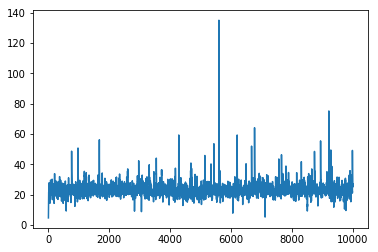

In [6]:
wd = WealthDynamics(ρ=0.1)

g, h = wd.update_function_builder()
w = wealth_time_series(wd.y_mean, 0.0, g, h, ts_length=10_000)

fig, ax = plt.subplots()
ax.plot(w)
plt.show()

Let's try again with higher correlation coefficient $\rho$:

Generated instance with stability coefficient α = 0.8031640592222655


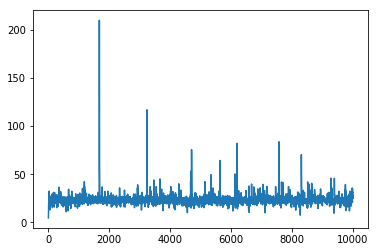

In [7]:
wd = WealthDynamics(ρ=0.75)

g, h = wd.update_function_builder()
w = wealth_time_series(wd.y_mean, 0.0, g, h, ts_length=10_000)

fig, ax = plt.subplots()
ax.plot(w)
plt.show()

And higher again:

Generated instance with stability coefficient α = 0.8031640592222655


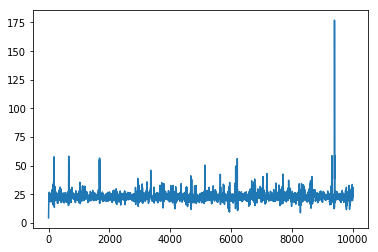

In [8]:
wd = WealthDynamics(ρ=0.95)

g, h = wd.update_function_builder()
w = wealth_time_series(wd.y_mean, 0.0, g, h, ts_length=10_000)

fig, ax = plt.subplots()
ax.plot(w)
plt.show()

### Application II: Size-Rank Plots

Let's look at how inequality varies with returns on financial assets.

In [12]:
def generate_size_rank_data(wd, num_households=250_000, T=10000):
    """
    Generate the Lorenz curve data and gini coefficient corresponding to a 
    WealthDynamics mode by simulating num_households forward to time T.
    """
    ψ_0 = np.ones(num_households) * wd.y_mean
    z_0 = 0.0

    ψ_star = cross_section_aggregate_z(wd, ψ_0, z_0, shift_length=T)
    ψ_star = - np.sort(- ψ_star) # Reverse sort
    w_vec = ψ_star[:int(num_households * 0.01)] # extract top 5%
    ydata = np.log(np.arange(len(w_vec)) + 1)
    xdata = np.log(w_vec)
    return xdata, ydata

Here's a rank-size plot for several different values of $\rho$, the correlation coefficient in the state process:

Generated instance with stability coefficient α = 0.8031640592222655
Generated instance with stability coefficient α = 0.8031640592222655
Generated instance with stability coefficient α = 0.8031640592222655


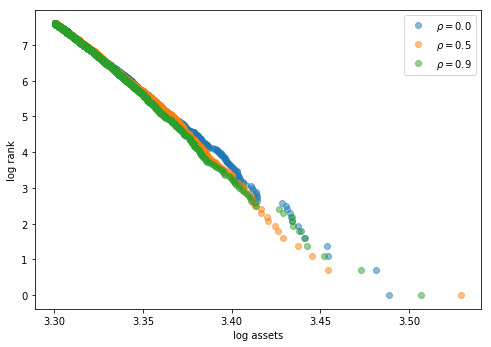

In [13]:
ρ_vals = 0.0, 0.5, 0.9
fig, ax = plt.subplots(figsize=(8, 5.5))

for ρ in ρ_vals:
    wd = WealthDynamics(ρ=ρ)
    xdata, ydata = generate_size_rank_data(wd, num_households=200_000)
    ax.plot(xdata, ydata, 'o', alpha=0.5, label=f'$\\rho = {ρ}$')

ax.set_ylabel("log rank")
ax.set_xlabel("log assets")

ax.legend()

plt.show()

Next we plot estimated Pareto exponent (computed via linear regression) against the correlation coefficient.

Generated instance with stability coefficient α = 0.8031640592222655
Generated instance with stability coefficient α = 0.8031640592222655
Generated instance with stability coefficient α = 0.8031640592222655
Generated instance with stability coefficient α = 0.8031640592222655
Generated instance with stability coefficient α = 0.8031640592222655


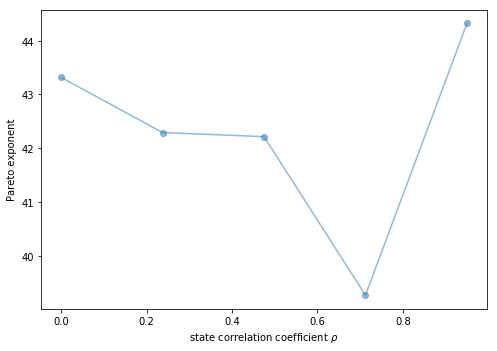

In [14]:
ρ_vals = np.linspace(0, 0.95, 5)
exponents = []
fig, ax = plt.subplots(figsize=(8, 5.5))

for ρ in ρ_vals:
    wd = WealthDynamics(ρ=ρ)
    xdata, ydata = generate_size_rank_data(wd, num_households=250_000)
    x = sm.add_constant(xdata)
    reg1 = sm.OLS(ydata, x)
    results = reg1.fit()
    exponents.append(abs(results.params[1]))
    
ax.plot(ρ_vals, exponents, 'o-', alpha=0.5)

ax.set_ylabel("Pareto exponent")
ax.set_xlabel("state correlation coefficient $\\rho$")

plt.show()